In [1]:
from haversine import haversine_vector, Unit
import os
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

import cmdstanpy
cmdstanpy.install_cmdstan()

Installing CmdStan version: 2.31.0
Install directory: /Users/andrea/.cmdstan
CmdStan version 2.31.0 already installed


True

In [2]:
import pandas as pd

source = "../house12latlong.csv"
df = pd.read_csv(source, index_col=0)
df['Latitude'] = df['Latitude'].str.replace(',', '.').astype(float)
df['Longitude'] = df['Longitude'].str.replace(',', '.').astype(float)
df

,price,Overall.Qual,Garage.Area,Total.Bsmt.SF,X1st.Flr.SF,Full.Bath,AgeofHouse,Mas.Vnr.Area,TotRms.AbvGrd,Fireplaces,Wood.Deck.SF,Open.Porch.SF,Longitude,Latitude
1,215000,6,528.0,1080.0,1656,1,50,112.0,7,2,210,62,-93.619754,42.054035
2,149900,6,452.0,1178.0,1293,2,52,28.0,5,0,280,0,-93.618462,42.053406
3,157500,6,313.0,1008.0,1024,1,50,244.0,5,2,0,0,-93.618182,42.053327
4,124500,6,502.0,882.0,882,1,53,0.0,5,0,0,0,-93.618895,42.053036
5,169000,5,963.0,1617.0,1797,1,49,302.0,7,1,0,0,-93.619262,42.053108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,170000,5,418.0,1389.0,1389,1,31,0.0,6,1,240,38,-93.600190,41.990921
2916,285000,8,482.0,1679.0,1803,2,15,0.0,6,2,129,64,-93.600006,41.989848
2917,188000,7,650.0,996.0,996,2,12,94.0,9,1,190,48,-93.599996,41.989265
2918,231000,6,616.0,1152.0,1152,2,16,0.0,7,1,162,312,-93.600147,41.989185


In [15]:
# We tested both ways to write the model
stan_model = CmdStanModel(stan_file="./spatial-with-effects.stan")
# stan_model = CmdStanModel(stan_file="./spatial-without-effects.stan")

11:07:54 - cmdstanpy - INFO - compiling stan file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects.stan to exe file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects
INFO:cmdstanpy:compiling stan file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects.stan to exe file /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects
DEBUG:cmdstanpy:cmd: make /tmp/tmprepacmyp/tmp9hhx6wv_
cwd: /Users/andrea/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/tmp/tmprepacmyp/tmp9hhx6wv_.hpp /tmp/tmprepacmyp/tm

In [16]:
indexes = df.index.copy().to_numpy()
np.random.shuffle(indexes)
small_df = df.loc[indexes[:300], :]

coords = small_df.loc[:, ["Latitude", "Longitude"]]
dists = haversine_vector(coords, coords, Unit.KILOMETERS, comb=True)

# Pre-compute the inverse of Sigma, so that we do not recompute it at each step within STAN
N = small_df.shape[0]
phi=0.7
delta = 1e-5
Sigma = np.ndarray((N,N))

for i in range(0, N):
    for j in range (0,N):
        Sigma[i, j] = np.exp((-1)*phi*dists[i,j]);
    Sigma[i, i]=Sigma[i,i]+delta;

Tau = np.linalg.inv(Sigma) 
(_, logDet) = np.linalg.slogdet(Sigma) # compute log(|det Sigma|)

In [17]:
features = small_df.loc[:, ["Overall.Qual", "Garage.Area", "Total.Bsmt.SF", "X1st.Flr.SF",
                "Mas.Vnr.Area", "TotRms.AbvGrd", "Fireplaces",
                "Wood.Deck.SF", "Full.Bath"]]
                
data = {
    "N": small_df.shape[0],
    "p": features.shape[1],
    "Y": np.log(small_df.loc[:, "price"]),
    "X": features,
    "dist": dists,
    "phi": phi,
    "priorsigma2": [5,1],
    "priortau2": [5,1],
    "Tau": Tau,
    "logDet": logDet,
}

stan_fit = stan_model.sample(data=data, chains=4, 
                             parallel_chains=4, 
                             iter_warmup=1000, iter_sampling=5000, max_treedepth=11)

cmdstanpy_data = az.from_cmdstanpy(stan_fit)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp9v064uuv/6zh2nj7p.json
DEBUG:cmdstanpy:cmd: /Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects info
cwd: None
11:07:59 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects', 'id=1', 'random', 'seed=32246', 'data', 'file=/tmp/tmp9v064uuv/6zh2nj7p.json', 'output', 'file=/tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=11', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects', 'id=2', 'random', 'se

11:21:59 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/andrea/Library/CloudStorage/OneDrive-Personal/Documenti/University/Note e file corsi/Bayesian Statistics/progetto/Spatial Modelling/spatial-with-effects', 'id=1', 'random', 'seed=32246', 'data', 'file=/tmp/tmp9v064uuv/6zh2nj7p.json', 'output', 'file=/tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'engine=nuts', 'max_depth=11', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_1.csv
 console_msgs (if any):
	/tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method =

11:22:00 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 8 divergent transitions (0.2%)
	Chain 1 had 4992 iterations at max treedepth (99.8%)
	Chain 2 had 11 divergent transitions (0.2%)
	Chain 2 had 4989 iterations at max treedepth (99.8%)
	Chain 3 had 5000 iterations at max treedepth (100.0%)
	Chain 4 had 5000 iterations at max treedepth (100.0%)
	Use function "diagnose()" to see further information.
	Chain 1 had 8 divergent transitions (0.2%)
	Chain 1 had 4992 iterations at max treedepth (99.8%)
	Chain 2 had 11 divergent transitions (0.2%)
	Chain 2 had 4989 iterations at max treedepth (99.8%)
	Chain 3 had 5000 iterations at max treedepth (100.0%)
	Chain 4 had 5000 iterations at max treedepth (100.0%)
	Use function "diagnose()" to see further information.


In [18]:
import pickle

# Save the result on disk
with open('spatial-stan-results.pickle', 'wb') as f:
    pickle.dump(stan_fit,f)

In [19]:
print(stan_fit.diagnose())

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/diagnose /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_1.csv /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_2.csv /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_3.csv /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_4.csv
cwd: None


Processing csv files: /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_1.csv, /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_2.csv, /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_3.csv, /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_4.csv

Checking sampler transitions treedepth.
19981 of 20000 (99.91%) transitions hit the maximum treedepth limit of 11, or 2^11 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
19 of 20000 (0.10%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sa

In [20]:
summary = stan_fit.summary()
summary

DEBUG:cmdstanpy:cmd: /Users/andrea/.cmdstan/cmdstan-2.31.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp9v064uuv/stansummary-spatial-with-effects-ho6ty4vc.csv /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_1.csv /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_2.csv /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_3.csv /tmp/tmp9v064uuv/spatial-with-effects3b7tsvt_/spatial-with-effects-20230211110759_4.csv
cwd: None


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,962.750000,2.675000,45.832800,890.542000,961.672000,1040.720000,293.56600,0.099433,1.01461
beta0,10.676400,0.134024,0.243595,10.223200,10.694400,11.029700,3.30349,0.001119,1.63360
beta[1],0.076913,0.002832,0.023200,0.037612,0.077268,0.115055,67.13130,0.022738,1.05282
beta[2],0.000234,0.000008,0.000104,0.000062,0.000235,0.000405,174.17600,0.058995,1.02133
beta[3],0.000047,0.000006,0.000075,-0.000076,0.000047,0.000170,148.58000,0.050325,1.03186
...,...,...,...,...,...,...,...,...,...
spatialEffect[296],0.314673,0.136880,0.223768,0.007890,0.267131,0.725574,2.67249,0.000905,2.09761
spatialEffect[297],0.051246,0.131855,0.208126,-0.218373,0.005281,0.444302,2.49149,0.000844,2.36968
spatialEffect[298],0.119169,0.135470,0.220051,-0.187532,0.075241,0.531281,2.63850,0.000894,2.25016
spatialEffect[299],0.028735,0.133449,0.213275,-0.257748,-0.007950,0.433130,2.55418,0.000865,2.22922


/Users/andrea/miniforge3/lib/python3.10/site-packages/arviz/plots/traceplot.py:215: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (312), generating only 20 plots
  warnings.warn(


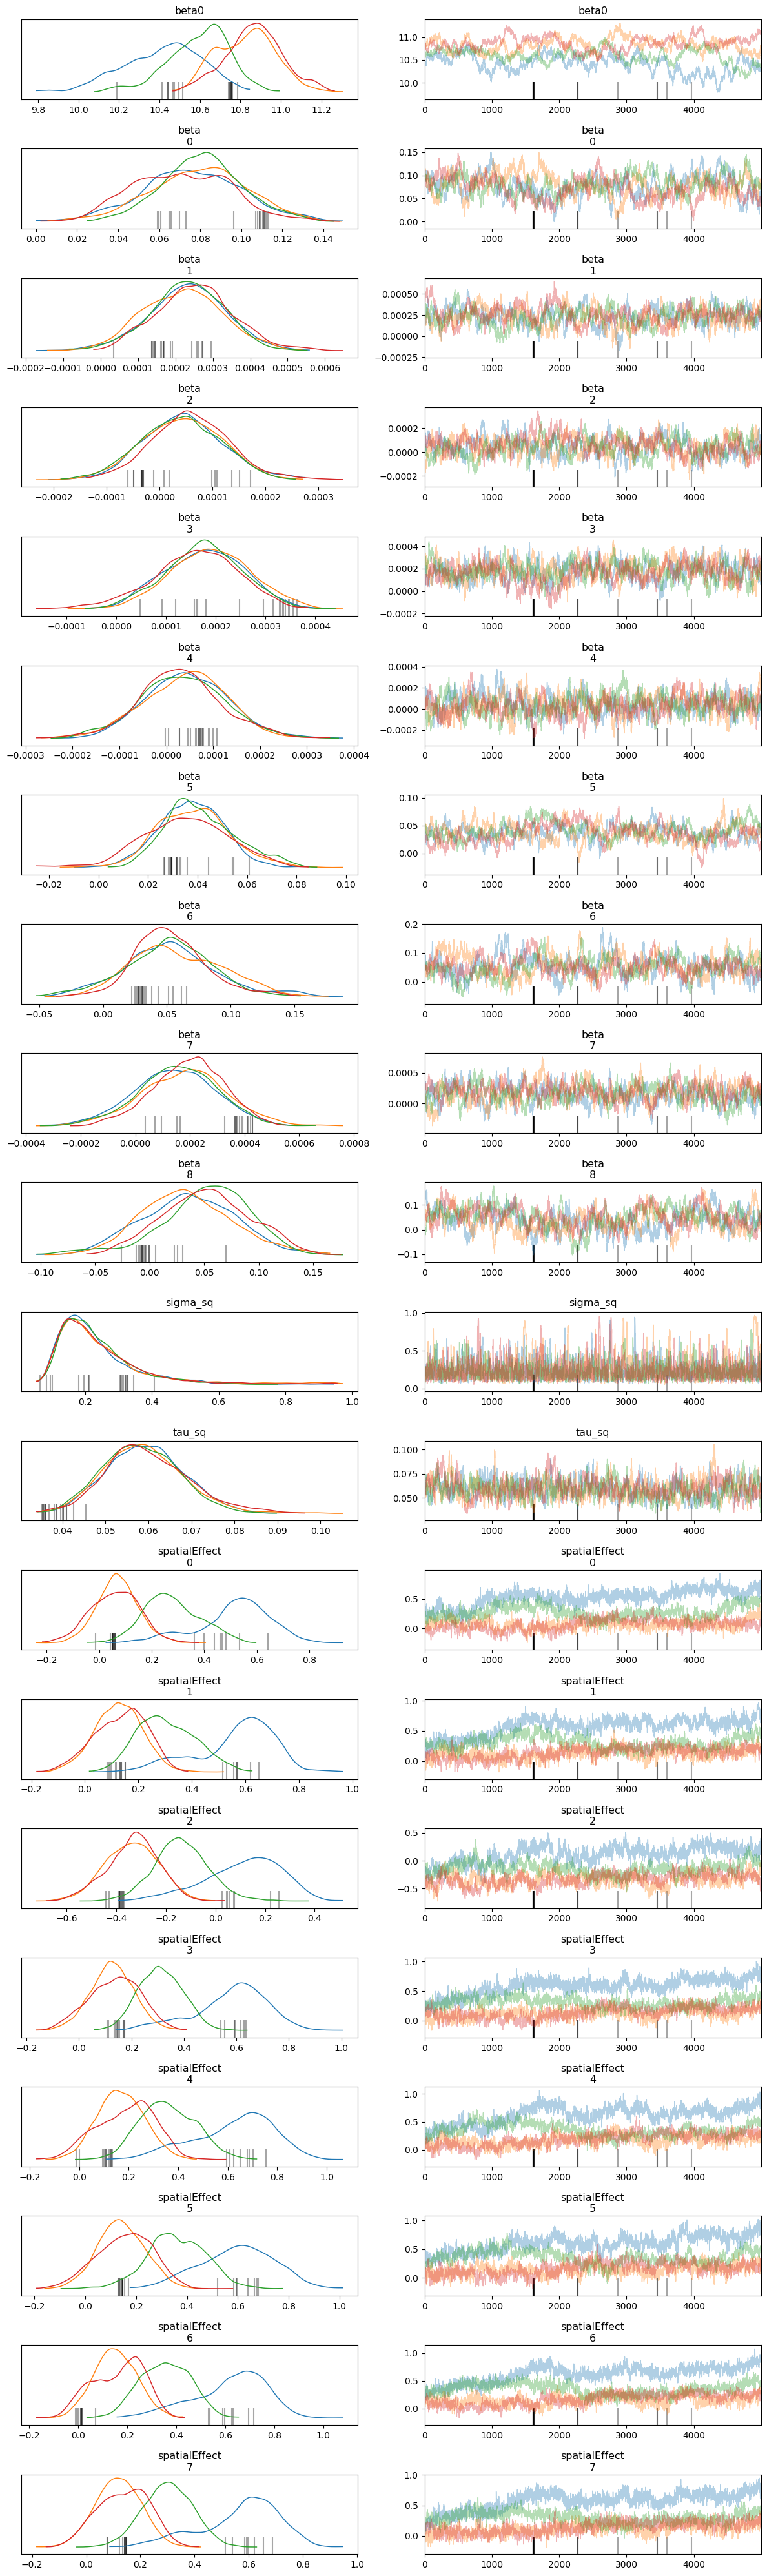

In [21]:
cmdstanpy_data = az.from_cmdstanpy(stan_fit)
az.plot_trace(cmdstanpy_data, compact=False)

plt.tight_layout()
# plt.savefig("ssvs-bsts.png")
plt.show()